# 第8章 函数和闭包
随着程序变大，需要某种方式将它们切成更小的、更便于管理的块。Scala提供了对有经验的程序员来说都很熟悉的方式来切分控制逻辑：将代码切成不同的函数。事实上，Scala提供了好几种Java中没有的方式来定义函数。除了方法（即那些以某个对象的成员形式存在的函数）之外，还有嵌套函数、函数字面量和函数值等。本章将带你领略Scala中所有这些函数形式。

## 8.1 方法
定义函数最常用的方式是作为某个对象的成员，这样的函数被称为方法（method）。例如，示例8.1展示了两个方法，合在一起读取给定名称的文件并打印出所有超过指定长度的行。在被打印的每一行之前都加上了该行所在的文件名。

In [ ]:
import scala.io.Source

object LongLines {

  def processFile(filename: String, width: Int) = {
    val source = Source.fromFile(filename)
    for (line <- source.getLines()) 
      processLine(filename, width, line)
  }

  private def processLine(filename: String,
      width: Int, line: String) = {

    if (line.length > width)
      println(filename + ": " + line.trim)
  }
}

LongLines.processFile("./build.sbt",20)



processFile方法接收filename和width作为参数。它从文件名创建了一个Source对象，然后在for表达式的生成器中，对源文件调用getLines。正如在第3章的第12步中提到的，getLines返回一个在每次迭代从文件读取一行并去掉最后的换行符的迭代器。for表达式通过调用助手方法processLine来处理每一行文本。
processLine方法接收三个参数：filename、width和line。它首先检查当前行的长度是否大于给定的宽度，如果是，则打印出文件名、一个冒号和该行文本。

为了从命令行使用LongLines，我们将创建一个以首个命令行参数作为宽度（width），并将后续入参当作文件名（filename）的应用程序：[1]

In [ ]:
object FindLongLines {
  def main(args: Array[String]) = {
    val width = args(0).toInt
    for (arg <- args.drop(1))
      LongLines.processFile(arg, width)
  } 
}

以下是如何用这个应用程序来找到LongLines.scala中长度超过45个字符的行（只有一行满足要求）：
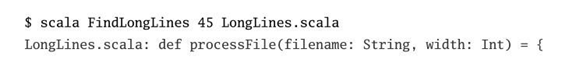
到目前为止，你看到的都跟使用任何面向对象语言的做法非常相似。不过，在Scala中函数这个概念比方法更通用。在接下来的几节我们将介绍Scala中表示函数的其他形式。

## 8.2 局部函数
前一节的processFile方法的构建展示了函数式编程风格的一个重要设计原则：程序应该被分解成许多小函数，每个函数都只做明确定义的任务。单个函数通常都很小。这种风格的好处是可以让程序员灵活地将许多构建单元组装起来，完成更复杂的任务。每个构建单元都应该足够简单，简单到能够单独理解的程度。
这种方式的一个问题是助手函数的名称会污染整个程序的命名空间。在解释器中，这并不是太大的问题，不过一旦函数被打包进可复用的类和对象当中，我们通常都希望类的使用者不要直接看到这些函数。它们离开了类和对象单独存在时通常都没有什么意义，而且通常你都希望在后续采用其他方式重写该类时，保留删除助手函数的灵活性。

在Java中，帮助你达到此目的的主要工具是私有方法。这种私有方法的方式在Scala中同样有效，如示例8.1所示，不过Scala还提供了另一种思路：可以在某个函数内部定义函数。就像局部变量一样，这样的局部函数只在包含它的代码块中可见。例如：

In [ ]:
import scala.io.Source

object LongLines {
    def processFile(filename: String, width: Int) = {
        def processLine(filename: String,
        width: Int, line: String) = {
            if (line.length > width)
                println(filename + ": " + line.trim)
        }
        
        val source = Source.fromFile(filename)
        for (line <- source.getLines())
            processLine(filename, width, line)
    }
}

LongLines.processFile("./build.sbt",20)

在本例中，我们对示例8.1原先的LongLines做了重构，将私有方法processLine转换成了一个局部函数。为此我们移除了private修饰符（这个修饰符只能也只需要加在成员上），并将processLine的定义放在了processFile的定义中。作为局部函数，processLine在processFile内有效，但不能从外部访问。

既然现在processLine定义在processFile内部，我们还可以做另一项改进。**注意到filename和width被直接透传给助手函数，完全没有变吗？这里的传递不是必须的，因为局部函数可以访问包含它们的函数的参数。可以直接使用外部的processFile函数的参数**，如示例8.2所示：


In [ ]:
import scala.io.Source

object LongLines {
    def processFile(filename: String, width: Int) = {
        def processLine(line: String) = {
            if (line.length > width)
                println(filename + ": " + line.trim)
        }
        
        val source = Source.fromFile(filename)
        for (line <- source.getLines())
            processLine(line)
    }
}

LongLines.processFile("./build.sbt",20)

这样更简单，不是吗？使用外层函数的参数是Scala提供的通用嵌套机制的常见而有用的示例。7.7节介绍的嵌套和作用域对Scala所有语法结构都适用，函数当然也不例外。这是个简单的原理，但非常强大，这一点在支持一等函数（first-class function）的编程语言中尤为突出。

## 8.3 一等函数
Scala支持一等函数。不仅可以定义函数并调用它们，还可以用匿名的字面量来编写函数并将它们作为值（value）进行传递。我们在第2章介绍了函数字面量，并在图2.2（31页）中展示了基本的语法。
**<u>lifoo：没有函数名的函数</u>**

函数字面量被编译成类，并在运行时实例化成函数值（function value）。[2]因此，函数字面量和函数值的区别在于，函数字面量存在于源码，而函数值以对象形式存在于运行时。这跟类（源码）与对象（运行时）的区别很相似。
以下是一个对某个数加1的函数字面量的简单示例：

In [ ]:
(x: Int) => x + 1

In [ ]:
=>表示该函数将左侧的内容（任何整数x）转换成右侧的内容（x + 1）。因此，这是一个将任何整数x映射成x + 1的函数。

函数值是对象，所以可以将它们存放在变量中。它们同时也是函数，所以也可以用常规的圆括号来调用它们。以下是对这两种操作的示例：

In [ ]:
var increase = (x: Int) => x + 1
increase(10)

由于本例中的increase是var，可以稍后将它赋值成其他函数值。

In [ ]:
increase = (x: Int) => x + 9999
increase(10)

如果你想要在函数字面量中包含多于1条语句，可以将函数体用花括号括起来，每条语句占一行，组成一个代码块（block）。跟方法一样，当函数值被调用时，所有的语句都会被执行，并且该函数的返回值就是对最后一个表达式求值的结果。

In [ ]:
increase = (x: Int) => {
    println("We")
    println("are")
    println("here!")
    x + 1
}

increase(10)

现在你已经看到了函数字面量和函数值的细节和用法。很多Scala类库都让你有机会使用它们。例如，所有的集合类都提供了foreach方法。[3]它接收一个函数作为入参，并对它的每个元素调用这个函数。如下是使用该方法打印列表中所有元素的例子：

In [ ]:
val someNumbers = List(-11, -10, -5, 0, 5, 10)

someNumbers.foreach((x: Int) => println(x))

再举个例子，集合类型还有个filter方法。这个方法从集合中选出那些满足由调用方指定的条件的元素。这个指定的条件由函数表示。例如，（x: Int）=> x > 0这个函数可以被用来做过滤。这个函数将所有正整数映射为true，而所有其他整数映射为false。如下是filter的具体用法：

In [ ]:
someNumbers.filter((x: Int) => x > 0)

像foreach和filter这样的方法会在后面的章节详细介绍。第16章会讲到它们在List类中的使用，第17章会讲到它们在其他集合类型中的用法。
## 8.4 函数字面量的简写形式
Scala提供了多个省去冗余信息，更简要地编写函数的方式。你需要留意这些机会，因为它们能帮助你去掉多余的代码。

一种让代码变得更简要的方式是略去参数类型声明。这样一来，前一个filter示例可以写成如下的样子：


In [ ]:
someNumbers.filter((x) => x > 0)

Scala编译器知道x必定是整数，因为它看到你立即用这个函数来过滤一个由整数组成的列表（someNumbers）。这被称作目标类型（target typing），因为一个表达式的目标使用场景（本例中它是传递给someNumbers.filter（）的参数）可以影响该表达式的类型（在本例中决定了x参数的类型）。目标类型这个机制的细节并不重要，可以不需要指明参数类型，直接使用函数字面量，当编译器报错时再加上类型声明。随着时间的推移，你会慢慢有感觉，什么时候编译器能帮你推断出类型，什么时候不可以。

另一个去除源码中无用字符的方式是**省去某个靠类型推断（而不是显式给出）的参数两侧的圆括号**。在前一例中，x两边的圆括号并不是必需的：

In [ ]:
someNumbers.filter(x => x > 0)

## 8.5 占位符语法
为了让函数字面量更加精简，还可以使用**下画线_**作为占位符，用来表示一个或多个参数，只要满足每个参数只在函数字面量中出现一次即可。例如，_ > 0是一个非常短的表示法，表示一个检查某个值是否大于0的函数：

In [ ]:
someNumbers.filter(_ > 0)

可以将下画线当成是表达式中的需要被“填”的“空”。函数每次被调用，这个“空”都会被一个入参“填”上。举例来说，如果someNumbers被初始化（146页）成List（-11, -10, -5, 0, 5, 10）,filter方法将首先把_ > 0中的空替换成-11，即-11 > 0，然后替换成-10，即-10 > 0，然后替换成-5，即-5 > 0，以此类推，直到List的末尾。因此，函数字面量_ > 0跟先前那个稍啰唆一些的x => x > 0是等价的，参考如下代码：

In [ ]:
someNumbers.filter(_ > 0)
someNumbers.filter(x => x > 0)

有时候当你用下画线为参数占位时，编译器可能并没有足够多的信息来推断缺失的参数类型。例如，假定你只是写了_ + _：

In [ ]:
val f = _ + _

在这类情况下，可以用冒号来给出类型，就像这样：

In [ ]:
val f = (_: Int) + (_: Int)

f(3,4)

意，_ + _将会展开成一个接收两个参数的函数字面量。这就是为什么只有当每个参数在函数字面量中出现不多不少正好一次的时候才能使用这样的精简写法。***多个下画线意味着多个参数***，而不是对单个参数的重复使用。第一个下画线代表第一个参数，第二个下画线代表第二个参数，第三个下画线代表第三个参数，以此类推。

## 8.6 部分应用的函数
虽然前面的例子用下画线替换掉单独的参数，**也可以用下画线替换整个参数列表**。例如，对于println（_），也可以写成println _。参考下面的例子：

In [ ]:
someNumbers.foreach(println _)

Scala会将这个简写形式当作如下完整形式看待：

In [ ]:
someNumbers.foreach(x => println(x))

因此，这里的下画线并非是单个参数的占位符，它是整个参数列表的占位符。注意你需要保留函数名和下画线之间的空格，否则编译器会认为你引用的是另一个符号，比如一个名为println_的方法，这个方法很可能并不存在。

当你这样使用下画线时，实际上是在编写一个部分应用的函数（partially applied function）。在Scala中，当你调用某个函数，传入任何需要的参数时，你实际上是应用那个函数到这些参数上 [4]。例如，给定如下的函数：

In [ ]:
def sum(a: Int,b: Int,c: Int) = a + b + c

可以像这样对入参1、2和3应用函数sum：

In [ ]:
sum(1,2,3)

部分应用的函数是一个表达式，在这个表达式中，并不给出函数需要的所有参数，而是给出部分，或完全不给。举例来说，要基于 sum创建一个部分应用的函数，假如你不想给出三个参数中的任何一个，可以在“sum”之后放一个下画线。这将返回一个函数，可以被存放到变量中。参考下面的例子：

In [ ]:
val a = sum _

有了这些代码，Scala编译器将根据部分应用函数sum _实例化一个接收三个整数参数的**函数值**，并将指向这个新的函数值的引用赋值给变量a。当你对三个参数应用这个新的函数值时，它将转而调用sum，传入这三个参数：

In [ ]:
a(1,2,3)

背后发生的事情是：名为a的变量指向一个函数值对象。这个函数值是一个从Scala编译器自动从s u m _这个部分应用函数表达式生成的类的实例。由编译器生成的这个类有一个接收三个参数的apply方法。[5]**生成的类的apply方法之所以接收三个参数，是因为表达式sum _缺失的参数个数为3**。Scala编译器将表达式a（1, 2, 3）翻译成对函数值的apply方法的调用，传入这三个参数1、2和3。因此，a（1, 2, 3）可以被看作是如下代码的简写形式：

In [ ]:
a.apply(1,2,3)

这个由Scala编译器从表达式sum _自动生成的类中定义的apply方法只是简单地将三个缺失的参数转发给sum，然后返回结果。在本例中，apply方法调用了sum（1, 2, 3），并返回sum的返回值，即6。

我们还可以从另一个角度来看待这类用下画线表示整个参数列表的表达式，即这是一种将def变成函数值的方式。举例来说，如果你有一个局部函数，比如sum（a: Int, b: Int, c: Int）: Int，可以将它“包”在一个函数值里，这个函数值拥有相同的参数列表和结果类型。当你应用这个函数值到某些参数时，它转而应用sum到同样的参数，并返回结果。**虽然不能将方法或嵌套的函数直接赋值给某个变量，或者作为参数传给另一个函数，可以将方法或嵌套函数打包在一个函数值里（具体来说就是在名称后面加上下画线）来完成这样的操作**。

至此，我们已经知道sum _是一个不折不扣的部分应用函数，可能你仍然感到困惑，为什么我们会这样称呼它。部分应用函数之所以叫作部分应用函数，是因为你并没有把那个函数应用到所有入参。拿sum _来说，你没有应用任何入参。不过，完全可以通过给出一些必填的参数来表达一个部分应用的函数。参考下面的例子：


In [ ]:
val b = sum(1, _: Int, 3)

在本例中，提供了第一个和最后一个参数给sum，但没有给出第二个参数。由于只有一个参数缺失，Scala编译器将生成一个新的函数类，这个类的apply方法接收一个参数。当我们用那个参数来调用这个新的函数时，这个生成的函数的apply方法将调用sum，依次传入1、传给当前函数的入参和3。参考下面的例子：

In [ ]:
b(2)

这里的b.apply调用了sum（1, 2, 3）。

In [ ]:
b(5)

而这里的b.apply调用了sum（1, 5, 3）。

如果你要的部分应用函数表达式并不给出任何参数，比如println _或sum _，可以在需要这样一个函数的地方更加精简地表示，连下画线也不用写。例如，可以不用像这样来打印someNumbers（146页）中的每个数,而是简单地写成：


In [ ]:
someNumbers.foreach(println _)
someNumbers.foreach(println)

**最后这种形式只在明确需要函数的地方被允许**，比如本例中的foreach调用。编译器知道这里需要的是一个函数，因为foreach要求一个函数作为入参。在那些并不需要函数的场合，尝试使用这样的形式会引发编译错误。参考下面的例子：

In [ ]:
val c = sum

In [ ]:
val d = sum _
d(10,20,30)

## 8.7 闭包
本章到目前为止，所有的函数字面量示例，都只是引用了传入的参数。例如，在（x: Int） => x > 0中，唯一在函数体x > 0中用到的变量是x，即这个函数的唯一参数。不过，也可以引用其他地方定义的变量：


In [ ]:
(x: Int) => x + more

这个函数将“more”也作为入参，不过more是哪里来的？从这个函数的角度来看，more是一个自由变量（free variable），因为函数字面量本身并没有给more赋予任何含义。相反，x是一个绑定变量（bound variable），因为它在该函数的上下文里有明确的含义：它被定义为该函数的唯一参数，一个Int。如果单独使用这个函数字面量，而并没有在任何处于作用域内的地方定义more，编译器将报错：

In [ ]:
(x: Int) => x + more

**为什么要多这么一个下画线？**  
Scala用于表示部分应用函数的语法体现了Scala在设计取舍方面跟其他经典函数式编程语言（比如Haskell或ML）的区别。在这些函数式语言当中，部分应用函数被当作默认的用法。不仅如此，这些语言拥有非常严格的静态类型系统，通常对于你在做部分应用时会犯的每一种错误都有明确的提示。Scala在这方面跟指令式编程语言（比如Java）更为接近，对于那些没有给出全部参数的方法，都认为是错误。还有，面向对象的传统的子类型和全局公共的根类型等特性允许某些在经典的函数式编程语言看来是有问题的程序通过编译。举例来说，假定你本来想调用List的tail（），但是却误用了drop（n: Int）。也就是说你忘记传入一个数值给drop，你可能会写“println（drop）”。如果Scala采纳了经典的函数式传统，即到处都允许部分应用的函数，这段代码会通过类型检查。但是，你可能会意外地发现，这句println打印出的输出永远都是\<function\>！这背后发生的是表达式drop被当作函数对象处理了。由于println接收任何类型的对象，这段代码能够正常编译，但结果并不是我们预期的。
    
要避免这类情况发生，Scala通常要求你明确指出那些你特意省去的参数，哪怕只是简单地加上_就好。Scala仅仅在明确预期函数类型的地方允许你省掉_。
    
另一方面，只要能找到名为more的变量，同样的函数字面量就能正常工作：


In [ ]:
var more = 1
val addMore = (x: Int) => x + more
addMore(10)

运行时从这个函数字面量创建出来的函数值（对象）被称作闭包（closure）。**该名称源于“捕获”其自由变量从而“闭合”该函数字面量的动作**。没有自由变量的函数字面量，比如（x: Int）=> x + 1，称为闭合语（closed term），这里的语（term）指的是一段源代码。因此，运行时从这个函数字面量创建出来的函数值严格来说并不是一个闭包，因为（x: Int） => x + 1按照目前这个写法已经是闭合的了。而运行时从任何带有自由变量的函数字面量，比如（x: Int） => x + more，创建的函数值，按照定义，要求捕获到它的自由变量more的绑定。相应的函数值结果（包含指向被捕获的more变量的引用）就被称作闭包，因为函数值是通过闭合这个开放语（open term）的动作产生的。

这个例子带来一个问题：如果more在闭包创建以后被改变会发生什么？在Scala中，答案是闭包能够看到这个改变。参考下面的例子：

In [ ]:
more = 9999
addMore(10)

很符合直觉的是，Scala的闭包捕获的是变量本身，而不是变量引用的值。[6]正如前面示例所展示的，为（x: Int） => x + more创建的闭包能够看到闭包外对more的修改。反过来也是成立的：闭包对捕获到的变量的修改也能在闭包外被看到。参考下面的例子：

In [ ]:
val someNumbers = List(-11, -10, -5, 0, 5, 10)
var sum = 0
someNumbers.foreach(sum += _)
sum

这个例子通过绕圈的方式来对List中的数字求和。sum这个变量位于函数字面量sum += _的外围作用域，这个函数将数字加给sum。虽然运行时是这个闭包对sum进行的修改，最终的结果-11仍然能被闭包外部看到。

那么如果一个闭包访问了某个随着程序运行会产生多个副本的变量会如何呢？例如，如果一个闭包使用了某个函数的局部变量，而这个函数又被调用了多次，会怎么样？闭包每次访问到的是这个变量的哪一个实例呢？

只有一个答案是跟Scala其他组成部分是一致的：闭包引用的实例是在闭包被创建时活跃的那一个。参考下面这个创建并返回“增加”闭包的函数：


In [ ]:
def makeIncreaser(more: Int) = (x: Int) => x + more

该函数每调用一次，就会创建一个新的闭包。每个闭包都会访问那个在它创建时活跃的变量more。

In [ ]:
val inc1 = makeIncreaser(1)
val inc9999 = makeIncreaser(9999)

当你调用makeIncreaser（1）时，一个捕获了more的绑定值1的闭包就被创建并返回出来。同理，当你调用makeIncreaser（9999）时，返回的是一个捕获了more的绑定值9999的闭包。当你将这些闭包应用到入参（本例中只有一个必选参数x），**其返回结果取决于闭包创建时more的定义**：

In [ ]:
inc1(10)
inc9999(10)

这里more是某次方法调用的入参，而方法已经返回了，不过这并没有影响。Scala编译器会重新组织和安排，让被捕获的参数在堆上继续存活。这样的安排都是由编译器自动帮我们完成的，你并不需要关心。看到喜欢的变量，只管捕获就好：val、var或者参数，都没问题。

## 8.8 特殊的函数调用形式
大多数你会遇到的函数和函数调用都会像你在本章到目前为止看到的那样。函数会有固定数量的形参，函数在调用时也会有相同数量的实参，而这些实参出现的顺序也会跟形参相同。

由于函数调用在Scala编程中的核心地位，对于某些特殊的需求，一些特殊形式的函数定义和调用方式也被加到了语言当中。Scala支持重复参数、带名字的参数和缺省参数。

**重复参数**  
Scala允许你标识出函数的最后一个参数可以被重复。这让我们可以对函数传入一个可变长度的参数列表。要表示这样一个重复参数，需要在参数的类型之后加上一个星号（*）。这样定义以后，echo可以用0到多个String参数调用：


In [ ]:
def echo(args: String*) = 
    for(arg <- args) println(arg)

echo()
echo("one")
echo("hello", "world")

在函数内部，这个重复参数的类型是一个所声明的参数类型的Array。因此，在echo函数内部，args的类型其实是Array[String]。尽管如此，如果你有一个合适类型的数组，并尝试将它作为重复参数传入时，你将得到一个编译错误：

In [ ]:
val arr = Array("What's", "up", "doc?")

echo(arr)

要完成这样的操作，你需要在数组实参的后面加上冒号和一个_*符号，就像这样：

In [ ]:
val arr = Array("What's", "up", "doc?")

echo(arr: _*)

这种表示法告诉编译器将arr的每个元素作为参数传给echo，而不是将所有元素放在一起作为单个实参传入。

**带名字的参数**  
在一个普通的函数调用中，实参是根据被调用的函数的参数定义，逐个匹配起来的：

In [ ]:
def speed(distance: Float, time: Float) = 
    distance / time

speed(100, 10)

在这个调用当中，100被匹配给distance而10被匹配给time。100和10这两个实参是按照形参被列出的顺序匹配起来的。

带名字的参数让你可以用不同的顺序将参数传给函数。其语法是简单地在每个实参前加上参数名和等号。例如，下面的这个对speed的调用等同于speed（100,10）：用带名字的参数发起调用，实参可以在不改变含义的前提下交换位置：

In [ ]:
speed(distance = 100, time = 10)
speed(time = 10, distance = 100)

我们还可以换用按位置和带名字的参数。这种情况下，按位置的参数需要放在前面。带名字的参数最常见的场合是跟缺省参数值一起使用。

**缺省参数值**  
Scala允许你给函数参数指定缺省值。这些有缺省值的参数可以不出现在在函数调用中，对应的参数将会被填充为缺省值。

示例8.3给出了这样的例子。printTime这个函数有一个参数out，其缺省值为Console.out。

In [ ]:
def printTime(out: java.io.PrintStream = Console.out) = 
    out.println("time = " + System.currentTimeMillis())

printTime()
printTime(Console.err)

如果你用printTime（）来调用这个函数，也就是不指定用于out的实参，那么out将会被设置为缺省值Console.out。也可以用一个显式给出的输出流来调用这个函数。例如，可以用printTime（Console.err）来将日志发送到标准错误输出。

缺省参数跟带名字的参数放在一起时尤为有用。在示例8.4中，函数functionTime2有两个可选参数。其中out参数有个缺省值Console.out，而divisor参数有一个缺省值1。

In [ ]:
def printTime2(out: java.io.PrintStream = Console.out, divisor: Int = 1) = 
    out.println("time = " + System.currentTimeMillis()/divisor)

函数printTime2可以用printTime2（）来调用，这样两个参数都被填充为缺省值。通过带名字的参数，这两个参数中的任何一个都可以被显式给出，而另一个将被填充为缺省值。要显式地给出输出流，可以这样写：

In [ ]:
printTime2(out = Console.err)

而要显式地给出时间的除数，可以这样做：

In [ ]:
printTime2(divisor = 1000)

## 8.9 尾递归
在7.2节，我们提到，如果要将一个不断更新var的while循环改写成只使用val的更加函数式的风格，可能需要用到递归。参考下面这个递归的函数例子，它通过反复改进猜测直到结果足够好的方式来取近似值：

In [ ]:
object Approximate {
  def isGoodEnough(guess: Double): Boolean = {
      println("guess [" + guess + "]")
      math.abs(guess*guess - 2.0)  <  1.0E-6
  }

  def improve(guess: Double): Double =
      (guess + 2.0/guess)/2.0
      
  def approximate(guess: Double): Double = 
    if (isGoodEnough(guess)) guess
    else approximate(improve(guess))
    
  //有了合适的isGoodEnough和improve的实现，像这样的函数通常被用于搜索。
  //如果你希望approximate函数跑得更快，你可能会想用while循环来尝试加快它的速度，就像这样：
  def approximateLoop(initialGuess: Double): Double = {
    var guess = initialGuess
    while (!isGoodEnough(guess))
      guess = improve(guess)
    guess
  }

  def main(args: Array[String]) {
    approximateLoop(3.3)
  }
}

Approximate.approximate(3.3)
Approximate.approximateLoop(3.3)

这两个版本的approximate到底哪一个更好呢？从代码简洁和避免使用var的角度，第一个函数式的版本胜出。不过指令式的方式是不是真的更高效呢？事实上，如果我们测量执行时间，这两个版本几乎完全一样！

这听上去有些出人意料，因为递归调用看上去比简单地从循环的末尾跳到开始要更“膨胀”。不过，在上面这个approximate的例子中，**Scala编译器能够执行一个重要的优化**。注意递归调用是approximate函数体在求值过程中的最后一步。像approximate这样在最后一步调用自己的函数，被称为尾递归（tail recursive）函数。Scala编译器能够检测到尾递归并将它替换成跳转到函数的最开始，并在跳转之前将参数更新为新的值。

这背后的意思是我们不应该回避使用递归算法来解决问题。通常，递归算法比基于循环的算法更加优雅、精简。如果解决方案是尾递归的，那么我们并不需要支付任何（额外的）运行时开销。

**跟踪尾递归函数**  
尾递归函数并不会在每次调用时构建一个新的栈帧，所有的调用都会在同一个栈帧中执行。这一点可能会出乎检查某个失败程序的栈跟踪信息（stack trace）的程序员的意料。例如，下面这个函数调用自己若干次之后抛出异常：

In [ ]:
def boom(x: Int): Int =
    if(x == 0) throw new Exception("boom!")
    else boom(x - 1) + 1

该函数并不是尾递归的，**因为它在递归调用之后还执行了一个递增操作**。在执行这段代码时，你将看到预期的效果：

In [ ]:
boom(3)

**尾递归优化**  
approximate编译后的代码本质上跟approximateLoop编译后的代码是一样的。两个函数都被编译成相同的13条指令的Java字节码。如果你仔细检查Scala编译器对尾递归的approximate生成的字节码，你会看到，虽然isGoodEnough和improve是在方法体内被调用的，approximate自己并没有。Scala编译器已经将递归调用优化掉了：
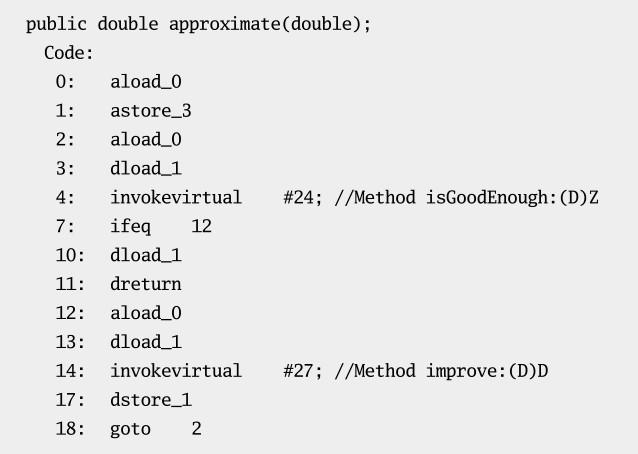

如果你把boom改成尾递归的：

In [ ]:
def bang(x: Int): Int =
    if(x == 0) throw new Exception("bang!")
    else bang(x - 1)

bang(5)

这一次，你将只会看到一个bang的栈帧。你可能会想是不是bang在调用自己之前就崩溃了，但事实并非如此。如果你觉得在看尾递归优化后的栈跟踪信息时会困惑，可以把它关掉，做法是给scala命令或scalac编译器如下参数：
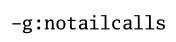
有了这个参数，你将得到一个更长的栈跟踪信息：
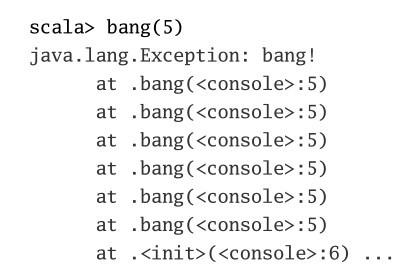
**尾递归的局限**  
在Scala中使用尾递归是比较受限的，因为用JVM指令集实现更高级形式的尾递归非常困难。Scala只能对那些直接尾递归**调用自己**的函数做优化。如果递归调用是间接的，比如如下示例中的两个相互递归的函数，Scala就没法优化它们：

In [ ]:
def isEven(x: Int): Boolean =
    if(x == 0) true else isOdd(x - 1)
def isOdd(x: Int): Boolean =
    if(x == 0) true else isEven(x - 1)

isEven(9)

同样地，如果最后一步调用的是一个函数值（而不是发起调用的那个函数自己），也无法享受到尾递归优化。参考下面这段递归程序：

In [ ]:
val funValue = nestedFun _
def nestedFun(x: Int) : Unit = {
    if(x != 0) {println(x); funValue(x-1)}
}

nestedFun(10)

funValue变量指向一个本质上只是打包了对nestedFun调用的函数值。当你应用这个函数到某个入参时，它转而将nestedFun应用到这个入参上，然后返回结果。因此，你可能希望Scala编译器能执行尾递归优化，不过编译器在这个情况下并不会这样做。**尾递归优化仅适用于某个方法或嵌套函数在最后一步操作中直接调用自己，并且没有经过函数值或其他中间环节的场合（如果你还没有完全理解尾递归，参考8.9节）**。


## 8.10 结语
本章带你全面地了解了Scala中的函数。不仅限于方法，Scala还提供了局部函数、函数字面量和函数值 ；不仅限于普通的函数调用，Scala还提供了部分应用的函数和带有重复参数的函数等。只要可能，函数调用都会以优化过后的尾部调用实现，因此许多看上去很漂亮的递归函数运行起来也能跟用while循环手工优化的版本一样快。下一章我们将在此基础上继续向你展示Scala对函数的丰富支持如何帮助你更好地对控制进行抽象。

________________________________________
[1].在本书里，我们通常不会在示例应用程序中检查命令行参数的有效性，这既是为了节约树木，同时也是为了减少那些可能会让示例中重要代码变得不那么直观的样板代码。这里做的取舍是，当遇到有问题的输入时，我们的应用程序会抛出异常，而不是产出有帮助的错误提示。  
[2].每个函数值都是某个扩展自scala包的FunctionN系列当中的一个特质的类的实例，比如Function0表示不带参数的函数，Function1表示带一个参数的函数，等等。每一个FunctionN特质都有一个apply方法用来调用该函数。  
[3].foreach方法定义在Traversable特质里，这是Lits、Set、Array和Map的通用超特质。详情请参考第17章。  
[4].通常我们会说对某些参数应用某个函数，根据上下文，有时候我们也会反过来说将某些参数应用到某个函数。——译者注  
[5].生成的类扩展自Function3这个特质，该特质声明了一个三参数的apply方法。  
[6].Java则不同，Java的内部类完全不允许我们访问外围作用域的可修改变量，所以本质上捕获变量和捕获它的值之间并没有差别。  
